# CFTC Disaggregated COT — Gold Positioning (API → Time Series)

**Author:** Dhruv Singh  
**Last updated:** 2025-12-15  

This notebook pulls **Commitments of Traders (COT)** data from the CFTC Public Reporting portal (Socrata / SODA API),
filters to **Gold** futures, engineers **net positioning** features by trader category, and visualizes positioning over time.

**Data source:** Disaggregated *Futures Only* report (publicreporting.cftc.gov), dataset id `72hh-3qpy`.

---
## Outline
1. Imports & configuration  
2. API request (with basic HTTP checks)  
3. Data cleaning & typing  
4. Feature engineering (net positions)  
5. Visualization & interpretation


## 1. Imports & configuration

In [1]:
import requests
import pandas as pd
pd.set_option('display.max_columns', None)

## 2. Pull the most recent 1000 rows for Gold

In [2]:
ENDPOINT = "https://publicreporting.cftc.gov/resource/72hh-3qpy.json"

In [3]:
ENDPOINT = "https://publicreporting.cftc.gov/resource/72hh-3qpy.json"

params = {
    "$select": "*",
    "$where": "commodity_name = 'GOLD' AND contract_market_name = 'GOLD'",
    "$order": "report_date_as_yyyy_mm_dd DESC",
    "$limit": 1000
}

r = requests.get(ENDPOINT, params=params, timeout=30)
r.raise_for_status()  # fail fast on HTTP errors
data = r.json()
len(data)


1000

### Quick JSON sanity-check (before converting to a DataFrame)

In [4]:
type(data), (list(data[0].keys())[:15] if data else None)

(list,
 ['id',
  'market_and_exchange_names',
  'report_date_as_yyyy_mm_dd',
  'yyyy_report_week_ww',
  'contract_market_name',
  'cftc_contract_market_code',
  'cftc_market_code',
  'cftc_region_code',
  'cftc_commodity_code',
  'commodity_name',
  'open_interest_all',
  'prod_merc_positions_long',
  'prod_merc_positions_short',
  'swap_positions_long_all',
  'swap__positions_short_all'])

In [5]:
df_gold_recent = pd.DataFrame(data)
df_gold_recent.head()

,id,market_and_exchange_names,report_date_as_yyyy_mm_dd,yyyy_report_week_ww,contract_market_name,cftc_contract_market_code,cftc_market_code,cftc_region_code,cftc_commodity_code,commodity_name,open_interest_all,prod_merc_positions_long,prod_merc_positions_short,swap_positions_long_all,swap__positions_short_all,swap__positions_spread_all,m_money_positions_long_all,m_money_positions_short_all,m_money_positions_spread,other_rept_positions_long,other_rept_positions_short,other_rept_positions_spread,tot_rept_positions_long_all,tot_rept_positions_short,nonrept_positions_long_all,nonrept_positions_short_all,open_interest_old,prod_merc_positions_long_1,prod_merc_positions_short_1,swap_positions_long_old,swap__positions_short_old,swap__positions_spread_old,m_money_positions_long_old,m_money_positions_short_old,m_money_positions_spread_1,other_rept_positions_long_1,other_rept_positions_short_1,other_rept_positions_spread_1,tot_rept_positions_long_old,tot_rept_positions_short_1,nonrept_positions_long_old,nonrept_positions_short_old,open_interest_other,prod_merc_positions_long_2,prod_merc_positions_short_2,swap_positions_long_other,swap__positions_short_other,swap__positions_spread_other,m_money_positions_long_other,m_money_positions_short_other,m_money_positions_spread_2,other_rept_positions_long_2,other_rept_positions_short_2,other_rept_positions_spread_2,tot_rept_positions_long_other,tot_rept_positions_short_2,nonrept_positions_long_other,nonrept_positions_short_other,change_in_open_interest_all,change_in_prod_merc_long,change_in_prod_merc_short,change_in_swap_long_all,change_in_swap_short_all,change_in_swap_spread_all,change_in_m_money_long_all,change_in_m_money_short_all,change_in_m_money_spread,change_in_other_rept_long,change_in_other_rept_short,change_in_other_rept_spread,change_in_tot_rept_long_all,change_in_tot_rept_short,change_in_nonrept_long_all,change_in_nonrept_short_all,pct_of_open_interest_all,pct_of_oi_prod_merc_long,pct_of_oi_prod_merc_short,pct_of_oi_swap_long_all,pct_of_oi_swap_short_all,pct_of_oi_swap_spread_all,pct_of_oi_m_money_long_all,pct_of_oi_m_money_short_all,pct_of_oi_m_money_spread,pct_of_oi_other_rept_long,pct_of_oi_other_rept_short,pct_of_oi_other_rept_spread,pct_of_oi_tot_rept_long_all,pct_of_oi_tot_rept_short,pct_of_oi_nonrept_long_all,pct_of_oi_nonrept_short_all,pct_of_open_interest_old,pct_of_oi_prod_merc_long_1,pct_of_oi_prod_merc_short_1,pct_of_oi_swap_long_old,pct_of_oi_swap_short_old,pct_of_oi_swap_spread_old,pct_of_oi_m_money_long_old,pct_of_oi_m_money_short_old,pct_of_oi_m_money_spread_1,pct_of_oi_other_rept_long_1,pct_of_oi_other_rept_short_1,pct_of_oi_other_rept_spread_1,pct_of_oi_tot_rept_long_old,pct_of_oi_tot_rept_short_1,pct_of_oi_nonrept_long_old,pct_of_oi_nonrept_short_old,pct_of_open_interest_other,pct_of_oi_prod_merc_long_2,pct_of_oi_prod_merc_short_2,pct_of_oi_swap_long_other,pct_of_oi_swap_short_other,pct_of_oi_swap_spread_other,pct_of_oi_m_money_long_other,pct_of_oi_m_money_short_other,pct_of_oi_m_money_spread_2,pct_of_oi_other_rept_long_2,pct_of_oi_other_rept_short_2,pct_of_oi_other_rept_spread_2,pct_of_oi_tot_rept_long_other,pct_of_oi_tot_rept_short_2,pct_of_oi_nonrept_long_other,pct_of_oi_nonrept_short_other,traders_tot_all,traders_prod_merc_long_all,traders_prod_merc_short_all,traders_swap_long_all,traders_swap_short_all,traders_swap_spread_all,traders_m_money_long_all,traders_m_money_short_all,traders_m_money_spread_all,traders_other_rept_long_all,traders_other_rept_short,traders_other_rept_spread,traders_tot_rept_long_all,traders_tot_rept_short_all,traders_tot_old,traders_prod_merc_long_old,traders_prod_merc_short_old,traders_swap_long_old,traders_swap_short_old,traders_swap_spread_old,traders_m_money_long_old,traders_m_money_short_old,traders_m_money_spread_old,traders_other_rept_long_old,traders_other_rept_short_1,traders_other_rept_spread_1,traders_tot_rept_long_old,traders_tot_rept_short_old,traders_tot_other,traders_prod_merc_long_other,traders_prod_merc_short_other,traders

In [6]:
df_gold_recent.columns

Index(['id', 'market_and_exchange_names', 'report_date_as_yyyy_mm_dd',
       'yyyy_report_week_ww', 'contract_market_name',
       'cftc_contract_market_code', 'cftc_market_code', 'cftc_region_code',
       'cftc_commodity_code', 'commodity_name',
       ...
       'conc_net_le_4_tdr_long_other', 'conc_net_le_4_tdr_short_other',
       'conc_net_le_8_tdr_long_other', 'conc_net_le_8_tdr_short_other',
       'contract_units', 'cftc_subgroup_code', 'commodity',
       'commodity_subgroup_name', 'commodity_group_name',
       'futonly_or_combined'],
      dtype='object', length=194)

In [7]:
df_gold_recent.shape

(1000, 194)

## 3. Clean & type columns

In [8]:
date_col = "report_date_as_yyyy_mm_dd"  # update if needed

In [9]:
df_gold_recent[date_col] = pd.to_datetime(df_gold_recent[date_col], errors="coerce")

In [10]:
df_gold_recent = df_gold_recent.sort_values(date_col).reset_index(drop=True)

In [11]:
df_gold_recent[[date_col, "contract_market_name", "commodity_name"]].tail()

,report_date_as_yyyy_mm_dd,contract_market_name,commodity_name
995,2025-10-21,GOLD,GOLD
996,2025-10-28,GOLD,GOLD
997,2025-11-04,GOLD,GOLD
998,2025-11-10,GOLD,GOLD
999,2025-11-18,GOLD,GOLD


In [12]:
[c for c in df_gold_recent.columns if "prod_merc_positions" in c or "swap" in c][:30]

['prod_merc_positions_long',
 'prod_merc_positions_short',
 'swap_positions_long_all',
 'swap__positions_short_all',
 'swap__positions_spread_all',
 'prod_merc_positions_long_1',
 'prod_merc_positions_short_1',
 'swap_positions_long_old',
 'swap__positions_short_old',
 'swap__positions_spread_old',
 'prod_merc_positions_long_2',
 'prod_merc_positions_short_2',
 'swap_positions_long_other',
 'swap__positions_short_other',
 'swap__positions_spread_other',
 'change_in_swap_long_all',
 'change_in_swap_short_all',
 'change_in_swap_spread_all',
 'pct_of_oi_swap_long_all',
 'pct_of_oi_swap_short_all',
 'pct_of_oi_swap_spread_all',
 'pct_of_oi_swap_long_old',
 'pct_of_oi_swap_short_old',
 'pct_of_oi_swap_spread_old',
 'pct_of_oi_swap_long_other',
 'pct_of_oi_swap_short_other',
 'pct_of_oi_swap_spread_other',
 'traders_swap_long_all',
 'traders_swap_short_all',
 'traders_swap_spread_all']

## 4. Feature engineering (net positions)

Net positions are computed as **Long − Short** for each trader category.

In [13]:
cols = [
    "report_date_as_yyyy_mm_dd",
    "contract_market_name",
    "open_interest_all",
    "prod_merc_positions_long",
    "prod_merc_positions_short",
    "swap_positions_long_all",
    "swap__positions_short_all",
    "m_money_positions_long_all",
    "m_money_positions_short_all",
]

In [14]:
df = df_gold_recent[cols].copy()

In [15]:
df.head()

,report_date_as_yyyy_mm_dd,contract_market_name,open_interest_all,prod_merc_positions_long,prod_merc_positions_short,swap_positions_long_all,swap__positions_short_all,m_money_positions_long_all,m_money_positions_short_all
0,2006-09-26,GOLD,322937,42960,116405,38469,60389,68325,33001
1,2006-10-03,GOLD,330065,46766,116196,39045,61609,66119,33666
2,2006-10-10,GOLD,334329,48112,114999,42818,58533,62270,39206
3,2006-10-17,GOLD,329875,46758,112417,40741,58220,64602,42773
4,2006-10-24,GOLD,331598,50694,112215,36478,55466,54019,43840


In [16]:
df["report_date_as_yyyy_mm_dd"] = pd.to_datetime(df["report_date_as_yyyy_mm_dd"], errors="coerce")

In [17]:
num_cols = [c for c in df.columns if c not in ["report_date_as_yyyy_mm_dd", "contract_market_name"]]

In [18]:
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

In [19]:
df["producer_net"] = df["prod_merc_positions_long"] - df["prod_merc_positions_short"]
df["swap_net"] = df["swap_positions_long_all"] - df["swap__positions_short_all"]
df["managed_money_net"] = df["m_money_positions_long_all"] - df["m_money_positions_short_all"]

In [20]:
df.tail()

,report_date_as_yyyy_mm_dd,contract_market_name,open_interest_all,prod_merc_positions_long,prod_merc_positions_short,swap_positions_long_all,swap__positions_short_all,m_money_positions_long_all,m_money_positions_short_all,producer_net,swap_net,managed_money_net
995,2025-10-21,GOLD,472421,13924,71702,56832,209171,135503,43276,-57778,-152339,92227
996,2025-10-28,GOLD,457122,12403,70597,48310,227143,138605,34446,-58194,-178833,104159
997,2025-11-04,GOLD,450399,9805,69256,47195,224286,130688,30143,-59451,-177091,100545
998,2025-11-10,GOLD,459997,9875,68621,43176,229253,134155,30068,-58746,-186077,104087
999,2025-11-18,GOLD,471953,10061,68958,44947,231635,130222,32017,-58897,-186688,98205


## 5. Visualization

Net positioning over time for Producer/Merchant, Swap Dealers, and Managed Money.

In [21]:
import matplotlib.pyplot as plt

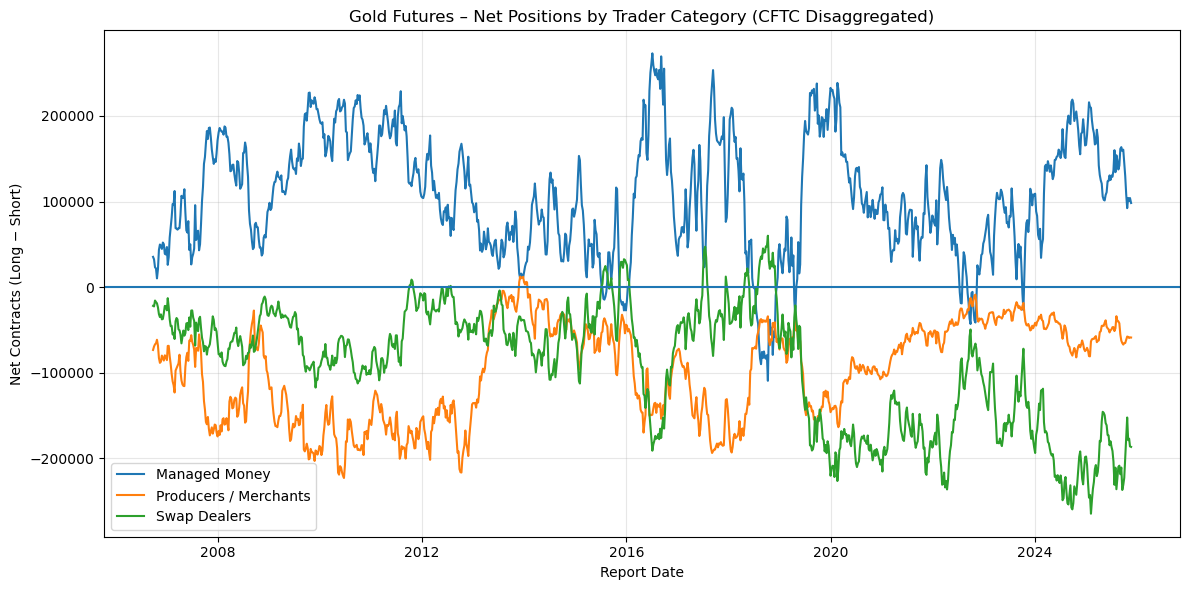

In [24]:
plt.figure(figsize=(12, 6))

plt.plot(df["report_date_as_yyyy_mm_dd"], df["managed_money_net"], label="Managed Money")
plt.plot(df["report_date_as_yyyy_mm_dd"], df["producer_net"], label="Producers / Merchants")
plt.plot(df["report_date_as_yyyy_mm_dd"], df["swap_net"], label="Swap Dealers")

plt.axhline(0)

plt.title("Gold Futures – Net Positions by Trader Category (CFTC Disaggregated)")
plt.xlabel("Report Date")
plt.ylabel("Net Contracts (Long − Short)")
plt.legend()

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# plt.savefig('assets/gold_net_positions.png', dpi=200)


## Interpretation (notes)

Use this section to add 2–3 concise takeaways, e.g.
- When Managed Money net positioning rises sharply, Producers/Swap Dealers often take the other side.
- Net positioning can be normalized by open interest for cross-period comparability.
- Consider comparing **GOLD** vs **MICRO GOLD** or adding z-scores/percentiles.

## Future work
- Parameterize the commodity/contract selection (reusable query template)
- Add optional API token support via `.env`
- Add normalization (net as % of open interest) and rolling z-scores
